In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)        
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

In [12]:
class Model:
    def __init__(self,n_epochs,Batchsize,learning_rate,Momentum=0.5,log_interval=10):
        self.network=LeNet()
        self.n_epochs=n_epochs
        self.Batchsize=Batchsize
        self.orig_learning_rate=learning_rate
        self.learning_rate=learning_rate
        self.momentum=Momentum
        self.log_interval=log_interval
        self.epochs=[]
        self.train_losses = []
        self.train_acc=[]
        self.test_losses = []
        self.test_acc=[]
        
        apply_transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor()])

        self.trainset=datasets.MNIST(root='./data',train=True,download=False,transform=apply_transform)
        self.train_loader=torch.utils.data.DataLoader(self.trainset,batch_size=self.Batchsize,shuffle=True)#create dataloader

        self.testset=datasets.MNIST(root='./data',train=False,download=True,transform=apply_transform)
        self.test_loader=torch.utils.data.DataLoader(self.testset,batch_size=self.Batchsize,shuffle=True)#create dataloader
    
    def speak(self):
        print("\n###########")
        print("LR: ",self.learning_rate)
        print("Batchsize: ",self.Batchsize)
        print("num_epochs: ",self.n_epochs)
        print(self.network)
        print("###########\n")
    
    def reset_learning_rate(self):
        self.learning_rate=self.orig_learning_rate
    
    def train(self,epoch):
        losses=[]
        self.network.train()
        optimizer = optim.SGD(self.network.parameters(), lr=self.learning_rate,
                          momentum=self.momentum)
        for batch_idx, (data, target) in enumerate(self.train_loader):
            optimizer.zero_grad()
            output = self.network(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
#             if batch_idx % 10 == 0:
#                 print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                     epoch, batch_idx * len(data), len(self.train_loader.dataset),
#                     100. * batch_idx / len(self.train_loader), loss.item()))
                #losses.append(loss.item())
                #train_counter.append(
                #(batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
                #torch.save(network.state_dict(), '/results/model.pth')
                #torch.save(optimizer.state_dict(), '/results/optimizer.pth')
        print("\nSUMMARY FOR EPOCH:",epoch)
        print("Average train loss for epoch number -->",epoch,"is : ",sum(losses)/len(losses))
        self.train_losses.append(sum(losses)/len(losses))
        self.epochs.append(epoch)   
    
    def check(self,epoch):
        self.network.eval()
        test_loss = 0
        correct = 0

        with torch.no_grad():
            for data, target in self.train_loader:
                output = self.network(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
        self.train_acc.append(100*correct.item()/len(self.train_loader.dataset))
        print("Training set accuracy:",100*correct.item()/len(self.train_loader.dataset))
        
        correct = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                output = self.network(data)
                test_loss += F.nll_loss(output, target, size_average=False).item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss =test_loss/len(self.test_loader.dataset)
        self.test_losses.append(test_loss)
        print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            test_loss, correct, len(self.test_loader.dataset),
            100* correct.item() / len(self.test_loader.dataset)))
        print("Test set accuracy:",100*correct.item()/len(self.test_loader.dataset))
        self.test_acc.append(100*correct.item()/len(self.test_loader.dataset))
        
    def run_training(self,vary_learning_rate_with_epochs=False):
        if(vary_learning_rate_with_epochs==False):
            for i in range(1, self.n_epochs + 1):
                self.train(i)
                self.check(i)
            return
        else:
            print("learning_rate=",self.learning_rate)
            for i in range(1, self.n_epochs + 1):
                if(i%5==0):
                    self.learning_rate=self.learning_rate/2;
                    print("learning_rate halved at epoch: ",i,". New learning_rate =",self.learning_rate)
                self.train(i)
                self.check(i)
            return
    def finaltrainaccuracy(self):
        return self.train_acc[-1]
    
    def finaltestaccuracy(self):
        return self.test_acc[-1]
    
    def finaltrainerror(self):
        return self.train_losses[-1]
    
    def finaltesterror(self):
        return self.test_losses[-1] 

In [13]:
n_epochs=20
Batchsize=128
learning_rate=0.025

In [14]:
classifier=Model(n_epochs,Batchsize,learning_rate)
classifier.speak()


###########
LR:  0.025
Batchsize:  128
num_epochs:  20
LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)
###########



In [15]:
classifier.run_training()


SUMMARY FOR EPOCH: 1
Average train loss for epoch number --> 1 is :  1.0037383216339897
Training set accuracy: 91.86333333333333


/home/nikhil/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Avg. loss: 0.2485, Accuracy: 9200/10000 (92%)
Test set accuracy: 92.0

SUMMARY FOR EPOCH: 2
Average train loss for epoch number --> 2 is :  0.18825717533289243
Training set accuracy: 95.19833333333334
Test set: Avg. loss: 0.1372, Accuracy: 9530/10000 (95%)
Test set accuracy: 95.3

SUMMARY FOR EPOCH: 3
Average train loss for epoch number --> 3 is :  0.11444449730153912
Training set accuracy: 97.30333333333333
Test set: Avg. loss: 0.0772, Accuracy: 9750/10000 (98%)
Test set accuracy: 97.5

SUMMARY FOR EPOCH: 4
Average train loss for epoch number --> 4 is :  0.08724653289349539
Training set accuracy: 97.91333333333333
Test set: Avg. loss: 0.0690, Accuracy: 9769/10000 (98%)
Test set accuracy: 97.69

SUMMARY FOR EPOCH: 5
Average train loss for epoch number --> 5 is :  0.07068028489648025
Training set accuracy: 97.94166666666666
Test set: Avg. loss: 0.0665, Accuracy: 9763/10000 (98%)
Test set accuracy: 97.63

SUMMARY FOR EPOCH: 6
Average train loss for epoch number --> 6 is :  0.06

# Question 4 #

## The loss used is negative log likelihood loss throughout and the same is used to denote error.

In [16]:
print("After",classifier.n_epochs," epochs of training with",classifier.learning_rate,"as learning rate and Batchsize=" ,classifier.Batchsize,":")
print("Training Accuracy: ",classifier.finaltrainaccuracy())
print("Testing Accuracy: ",classifier.finaltestaccuracy())
print("Training Loss: ",classifier.finaltrainerror())
print("Testing Loss: ",classifier.finaltesterror())

After 20  epochs of training with 0.025 as learning rate and Batchsize= 128 :
Training Accuracy:  99.51333333333334
Testing Accuracy:  98.92
Training Loss:  0.017528087811121074
Testing Loss:  0.03548501246348024


# Question 5

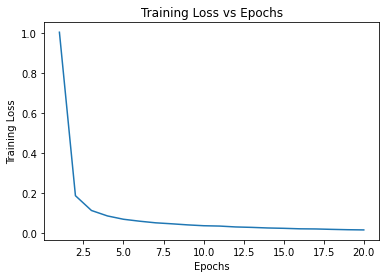

In [17]:
plt.plot(classifier.epochs,classifier.train_losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.show()

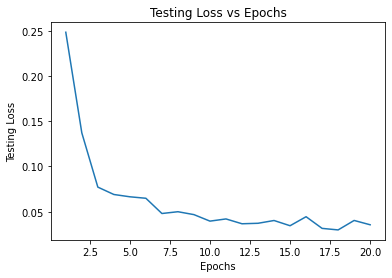

In [18]:
plt.plot(classifier.epochs,classifier.test_losses)
plt.xlabel("Epochs")
plt.ylabel("Testing Loss")
plt.title("Testing Loss vs Epochs")
plt.show()

# Question 6

## The following starts question 6 (a):

In [19]:
n_epochs=20
learning_rate=0.025
batchsizes=[32,64,128,256,512]
corresponding_final_train_error=[]
corresponding_final_test_error=[]
for i in range(len(batchsizes)):
    mod_obj=Model(n_epochs,batchsizes[i],learning_rate)
    mod_obj.speak()
    mod_obj.run_training()
    corresponding_final_train_error.append(mod_obj.finaltrainerror())
    corresponding_final_test_error.append(mod_obj.finaltesterror())


###########
LR:  0.025
Batchsize:  32
num_epochs:  20
LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)
###########


SUMMARY FOR EPOCH: 1
Average train loss for epoch number --> 1 is :  0.3687677613767485
Training set accuracy: 96.955
Test set: Avg. loss: 0.0880, Accuracy: 9702/10000 (97%)
Test set accuracy: 97.02

SUMMARY FOR EPOCH: 2
Average train loss for epoch number --> 2 is :  0.08175576013817142
Training set accuracy: 97.95333333333333
Test set: Avg. loss: 0.0724, Accuracy: 9776/10000 (98%)
Test set accuracy: 97.76

SUMMARY 

Test set: Avg. loss: 0.0374, Accuracy: 9888/10000 (99%)
Test set accuracy: 98.88

SUMMARY FOR EPOCH: 15
Average train loss for epoch number --> 15 is :  0.013819788773659554
Training set accuracy: 99.64833333333333
Test set: Avg. loss: 0.0358, Accuracy: 9889/10000 (99%)
Test set accuracy: 98.89

SUMMARY FOR EPOCH: 16
Average train loss for epoch number --> 16 is :  0.011958504608682871
Training set accuracy: 99.63666666666667
Test set: Avg. loss: 0.0387, Accuracy: 9890/10000 (99%)
Test set accuracy: 98.9

SUMMARY FOR EPOCH: 17
Average train loss for epoch number --> 17 is :  0.011767564138583366
Training set accuracy: 99.65833333333333
Test set: Avg. loss: 0.0400, Accuracy: 9898/10000 (99%)
Test set accuracy: 98.98

SUMMARY FOR EPOCH: 18
Average train loss for epoch number --> 18 is :  0.009630894850007477
Training set accuracy: 99.82
Test set: Avg. loss: 0.0341, Accuracy: 9899/10000 (99%)
Test set accuracy: 98.99

SUMMARY FOR EPOCH: 19
Average train loss for epoch number --> 19 is :  

Training set accuracy: 98.10666666666667
Test set: Avg. loss: 0.0585, Accuracy: 9814/10000 (98%)
Test set accuracy: 98.14

SUMMARY FOR EPOCH: 9
Average train loss for epoch number --> 9 is :  0.06260458178263395
Training set accuracy: 98.255
Test set: Avg. loss: 0.0527, Accuracy: 9822/10000 (98%)
Test set accuracy: 98.22

SUMMARY FOR EPOCH: 10
Average train loss for epoch number --> 10 is :  0.057739037540840345
Training set accuracy: 98.40333333333334
Test set: Avg. loss: 0.0511, Accuracy: 9816/10000 (98%)
Test set accuracy: 98.16

SUMMARY FOR EPOCH: 11
Average train loss for epoch number --> 11 is :  0.053449080468333784
Training set accuracy: 98.38833333333334
Test set: Avg. loss: 0.0537, Accuracy: 9821/10000 (98%)
Test set accuracy: 98.21

SUMMARY FOR EPOCH: 12
Average train loss for epoch number --> 12 is :  0.04884969491828629
Training set accuracy: 98.35833333333333
Test set: Avg. loss: 0.0551, Accuracy: 9827/10000 (98%)
Test set accuracy: 98.27

SUMMARY FOR EPOCH: 13
Average tr

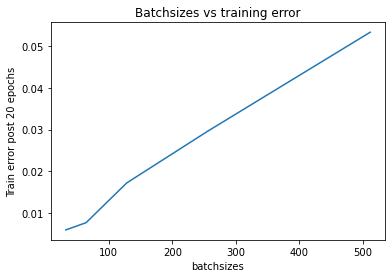

In [20]:
plt.plot(batchsizes,corresponding_final_train_error)
plt.xlabel("batchsizes")
plt.ylabel("Train error post 20 epochs")
plt.title("Batchsizes vs training error")
plt.show()

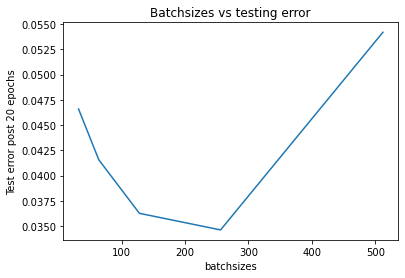

In [21]:
plt.plot(batchsizes,corresponding_final_test_error)
plt.xlabel("batchsizes")
plt.ylabel("Test error post 20 epochs")
plt.title("Batchsizes vs testing error")
plt.show()

## Question 6 (B):

In [22]:
n_epochs=20
learning_rates=[0.025,0.05,0.1,0.2,0.5]
batchsize=64
corresponding_final_train_error_vlr=[]
corresponding_final_test_error_vlr=[]
for i in range(len(learning_rates)):
    mod_obj=Model(n_epochs,batchsize,learning_rates[i])
    mod_obj.speak()
    mod_obj.run_training()
    corresponding_final_train_error_vlr.append(mod_obj.finaltrainerror())
    corresponding_final_test_error_vlr.append(mod_obj.finaltesterror())


###########
LR:  0.025
Batchsize:  64
num_epochs:  20
LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)
###########


SUMMARY FOR EPOCH: 1
Average train loss for epoch number --> 1 is :  0.6989059035620614
Training set accuracy: 95.40166666666667
Test set: Avg. loss: 0.1352, Accuracy: 9554/10000 (96%)
Test set accuracy: 95.54

SUMMARY FOR EPOCH: 2
Average train loss for epoch number --> 2 is :  0.10693110132005129
Training set accuracy: 96.95833333333333
Test set: Avg. loss: 0.0878, Accuracy: 9729/10000 (97%)
Test set accuracy: 97.2

Test set: Avg. loss: 0.0431, Accuracy: 9883/10000 (99%)
Test set accuracy: 98.83

SUMMARY FOR EPOCH: 15
Average train loss for epoch number --> 15 is :  0.008122855166296319
Training set accuracy: 99.85666666666667
Test set: Avg. loss: 0.0375, Accuracy: 9899/10000 (99%)
Test set accuracy: 98.99

SUMMARY FOR EPOCH: 16
Average train loss for epoch number --> 16 is :  0.007266736729371802
Training set accuracy: 99.76666666666667
Test set: Avg. loss: 0.0366, Accuracy: 9894/10000 (99%)
Test set accuracy: 98.94

SUMMARY FOR EPOCH: 17
Average train loss for epoch number --> 17 is :  0.005738718668271371
Training set accuracy: 99.73666666666666
Test set: Avg. loss: 0.0414, Accuracy: 9891/10000 (99%)
Test set accuracy: 98.91

SUMMARY FOR EPOCH: 18
Average train loss for epoch number --> 18 is :  0.0058118765600602956
Training set accuracy: 99.86333333333333
Test set: Avg. loss: 0.0379, Accuracy: 9901/10000 (99%)
Test set accuracy: 99.01

SUMMARY FOR EPOCH: 19
Average train loss for epoch number

Training set accuracy: 99.12666666666667
Test set: Avg. loss: 0.0572, Accuracy: 9851/10000 (99%)
Test set accuracy: 98.51

SUMMARY FOR EPOCH: 9
Average train loss for epoch number --> 9 is :  0.017870154848017385
Training set accuracy: 99.705
Test set: Avg. loss: 0.0475, Accuracy: 9887/10000 (99%)
Test set accuracy: 98.87

SUMMARY FOR EPOCH: 10
Average train loss for epoch number --> 10 is :  0.01596883698983856
Training set accuracy: 99.555
Test set: Avg. loss: 0.0527, Accuracy: 9882/10000 (99%)
Test set accuracy: 98.82

SUMMARY FOR EPOCH: 11
Average train loss for epoch number --> 11 is :  0.014049774936154214
Training set accuracy: 99.68666666666667
Test set: Avg. loss: 0.0473, Accuracy: 9889/10000 (99%)
Test set accuracy: 98.89

SUMMARY FOR EPOCH: 12
Average train loss for epoch number --> 12 is :  0.014131973564242891
Training set accuracy: 99.59833333333333
Test set: Avg. loss: 0.0578, Accuracy: 9867/10000 (99%)
Test set accuracy: 98.67

SUMMARY FOR EPOCH: 13
Average train loss f

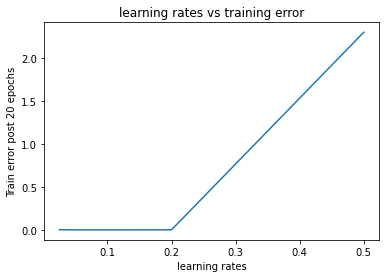

In [23]:
plt.plot(learning_rates,corresponding_final_train_error_vlr)
plt.xlabel("learning rates")
plt.ylabel("Train error post 20 epochs")
plt.title("learning rates vs training error")
plt.show()

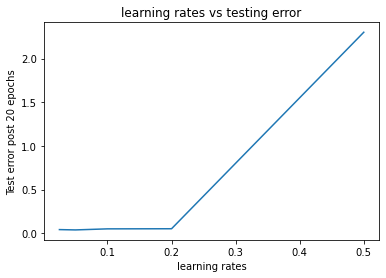

In [24]:
plt.plot(learning_rates,corresponding_final_test_error_vlr)
plt.xlabel("learning rates")
plt.ylabel("Test error post 20 epochs")
plt.title("learning rates vs testing error")
plt.show()

### According to the above graph, learning rate of around 0.2 converges the most quickly and hence we use some learning rate around it

## Question 6(c)

### The strategy that we use to decrease the learning rate here is that after every five epochs, we half the current learning rate. And thus we see the results. Starting learning rate would be 0.05. After 5 epochs it will update to 0.025, and so on. This can be done by passing the flag as True for varying learning rate when calling train of the object. It is implemented inside the running training. Please have a look above in the class Model.

In [25]:
n_epochs=20
learning_rate=0.05
batchsize=64
mod_obj=Model(n_epochs,batchsize,learning_rate)
mod_obj.speak()
mod_obj.run_training(vary_learning_rate_with_epochs=True)


###########
LR:  0.05
Batchsize:  64
num_epochs:  20
LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)
###########

learning_rate= 0.05

SUMMARY FOR EPOCH: 1
Average train loss for epoch number --> 1 is :  0.36193238580023557
Training set accuracy: 96.82
Test set: Avg. loss: 0.0947, Accuracy: 9692/10000 (97%)
Test set accuracy: 96.92

SUMMARY FOR EPOCH: 2
Average train loss for epoch number --> 2 is :  0.07771933295189151
Training set accuracy: 98.32333333333334
Test set: Avg. loss: 0.0554, Accuracy: 9824/10000 (98%)
Test set accura

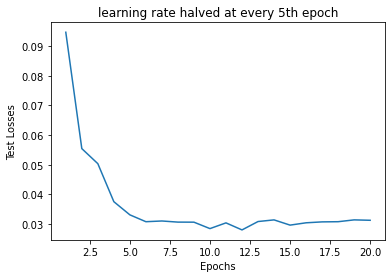

In [26]:
plt.plot(mod_obj.epochs,mod_obj.test_losses)
plt.xlabel("Epochs")
plt.ylabel("Test Losses")
plt.title("learning rate halved at every 5th epoch")
plt.show()

We observe that the curve becomes more gentle and converges more smoothly.